# Notebook to segment fetal images using different methods

Class description:

    Label: 0 (Background)
    Label: 1 (third_sylvian, line)
    Label: 2 (third_midline, line)
    Label: 3 (third_cavum, area)
    Label: 4 (third_cerebellum, area)

Channel description:

    Channel: 1 (grayscale)

In [1]:
import os
import time
import warnings
from time import strftime
from functools import partial

from PIL import Image

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from skimage import io as skio
from scipy.special import expit, softmax

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as func

from datasets import FetalDataset
from models import FCN_ResNet50, FCN_ResNet101, LRASPP_MobileNet
from models import DeeplabV3_MobileNet, DeeplabV3_ResNet50, Unet2D
from utils import color_codes, time_to_string, normalise

The imports can be divided into a few different groups:
- **General packages**: This group include basic python libraries (included with any distribution of python) to perform basic operations relations to files, measuring execution time or function utilities.
- **Image packages**: This dataset uses a specific type of GeoTIFF files (?). To open them we will be using image libraries focused on TIFF files.
- **Plotting tools**: matplotlib (and seaborn) is the most commonly useful visualisation tool for plotting results.
- **Scientific tools**: This larger group includes numpy (equivalent to matlab array processing), scipy (numpy extension for scientific projects) and sklearn (and its image analysis extension). These packages provide tools to manipulate data.
- **Autodifferentiable packages**: For this notebook we will be using pytorch as our tool to build and train deep learning models.
- **Tools from the repository**: To simplify our networks, some of the meaty code is stored on a relevant file including dataset implementations, models based on torchvision and other utils.

# Reading Data
  

In [2]:
path = './data/Final_round'

lDict = {"third_sylvian" : (1,False), "third_midline": (2,False), "third_cavum": (3,True), "third_cerebellum":(4,True)} 

FRds = FetalDataset(path,lDict)

In [9]:
def visualize_fetal_dataset(dataset, n=3):
    """
    Display `n` samples from a FetalDataset instance.
    
    Each sample shows:
    - The ultrasound image
    - The corresponding label mask
    """
    for i in range(min(n, len(dataset))):
        us_image, label_mask = dataset[i]

        fig, axes = plt.subplots(1, 3, figsize=(10, 5))

        axes[0].imshow(us_image, cmap='gray')
        axes[0].set_title("Ultrasound Image")
        axes[0].axis("off")

        axes[1].imshow(label_mask, cmap='tab10', vmin=0)
        axes[1].set_title("Label Mask")
        axes[1].axis("off")

        axes[2].imshow(us_image, cmap='gray')
        axes[2].imshow(label_mask, cmap='tab10', vmin=0, alpha = 0.2)
        axes[2].set_title("overlay")
        axes[2].axis("off")

        plt.tight_layout()
        plt.show()

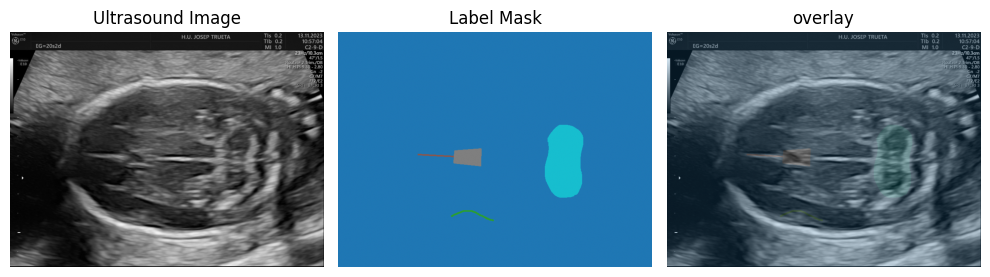

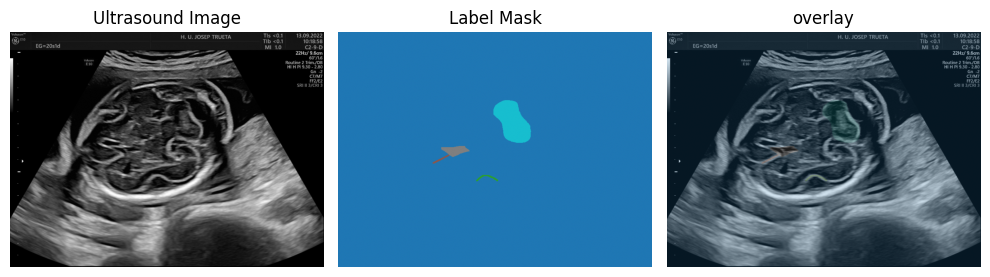

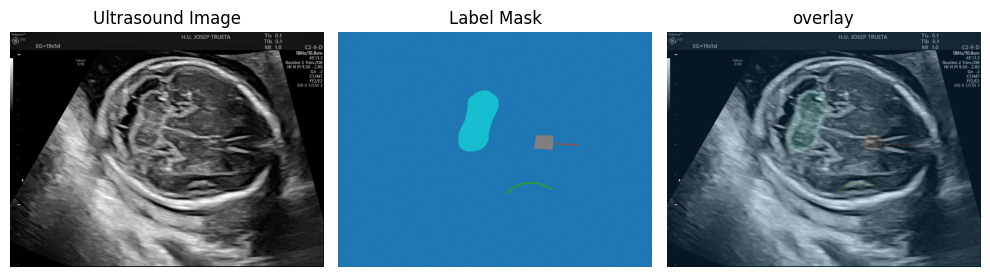

In [10]:
visualize_fetal_dataset(FRds)